In [22]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import glob
from PIL import Image
import os
from google.colab import drive
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.applications import VGG16
from keras.layers import Flatten, Dense
from sklearn.metrics import classification_report

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
DIR_PATH = '/content/drive/MyDrive/Colab Notebooks/fruits/train'

FOLDER_PATH = Path(DIR_PATH)

file_paths = list(FOLDER_PATH.glob('**/*.jpeg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], file_paths))

file_paths = pd.Series(file_paths, name='File_Paths').astype(str)
labels = pd.Series(labels, name='Labels')

df = pd.concat([file_paths, labels], axis=1)

df

,File_Paths,Labels
0,/content/drive/MyDrive/Colab Notebooks/fruits/...,strawberries
1,/content/drive/MyDrive/Colab Notebooks/fruits/...,strawberries
2,/content/drive/MyDrive/Colab Notebooks/fruits/...,strawberries
3,/content/drive/MyDrive/Colab Notebooks/fruits/...,strawberries
4,/content/drive/MyDrive/Colab Notebooks/fruits/...,strawberries
...,...,...
2346,/content/drive/MyDrive/Colab Notebooks/fruits/...,orange
2347,/content/drive/MyDrive/Colab Notebooks/fruits/...,orange
2348,/content/drive/MyDrive/Colab Notebooks/fruits/...,orange
2349,/content/drive/MyDrive/Colab Notebooks/fruits/...,orange


In [4]:
TEST_DIR_PATH = '/content/drive/MyDrive/Colab Notebooks/fruits/test'

TEST_FOLDER_PATH = Path(TEST_DIR_PATH)

test_file_paths = list(TEST_FOLDER_PATH.glob('**/*.jpeg'))
test_labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], test_file_paths))

test_file_paths = pd.Series(test_file_paths, name='File_Paths').astype(str)
test_labels = pd.Series(test_labels, name='Labels')

test_df = pd.concat([test_file_paths, test_labels], axis=1)

test_df

,File_Paths,Labels
0,/content/drive/MyDrive/Colab Notebooks/fruits/...,avocado
1,/content/drive/MyDrive/Colab Notebooks/fruits/...,avocado
2,/content/drive/MyDrive/Colab Notebooks/fruits/...,avocado
3,/content/drive/MyDrive/Colab Notebooks/fruits/...,avocado
4,/content/drive/MyDrive/Colab Notebooks/fruits/...,avocado
...,...,...
1020,/content/drive/MyDrive/Colab Notebooks/fruits/...,cherry
1021,/content/drive/MyDrive/Colab Notebooks/fruits/...,cherry
1022,/content/drive/MyDrive/Colab Notebooks/fruits/...,cherry
1023,/content/drive/MyDrive/Colab Notebooks/fruits/...,cherry


In [5]:
df['Labels'].value_counts()

Labels
cherry          280
mango           231
pinenapple      230
strawberries    230
Apple           230
avocado         230
kiwi            230
Banana          230
watermelon      230
orange          230
Name: count, dtype: int64

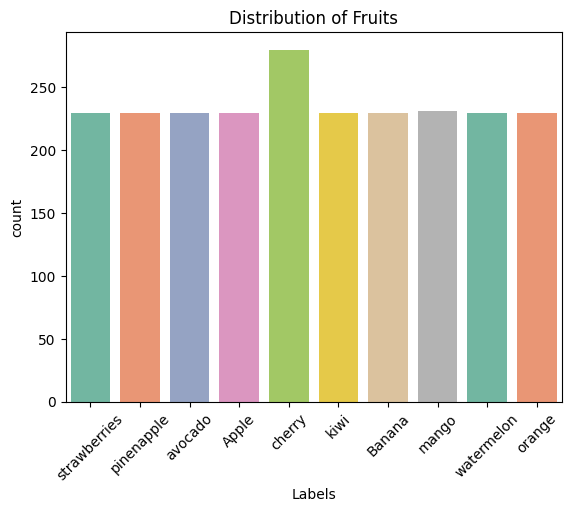

In [6]:
plt.title('Distribution of Fruits')
sns.countplot(data=df, x=df['Labels'], hue=df['Labels'], palette='Set2')
plt.xticks(rotation=45)

plt.show()

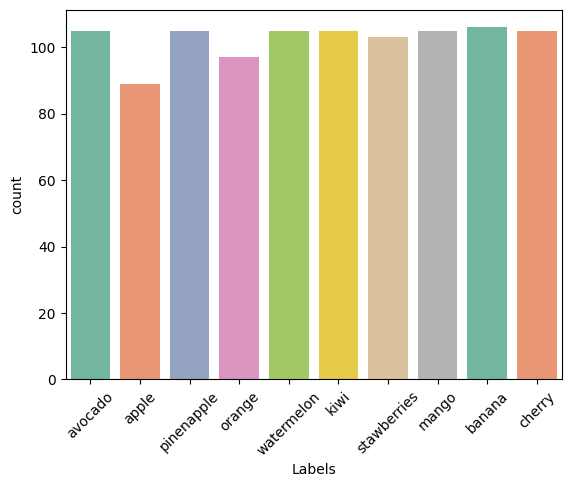

In [7]:
sns.countplot(data=test_df, x=test_df['Labels'], hue=test_df['Labels'], palette='Set2')
plt.xticks(rotation=45)

plt.show()

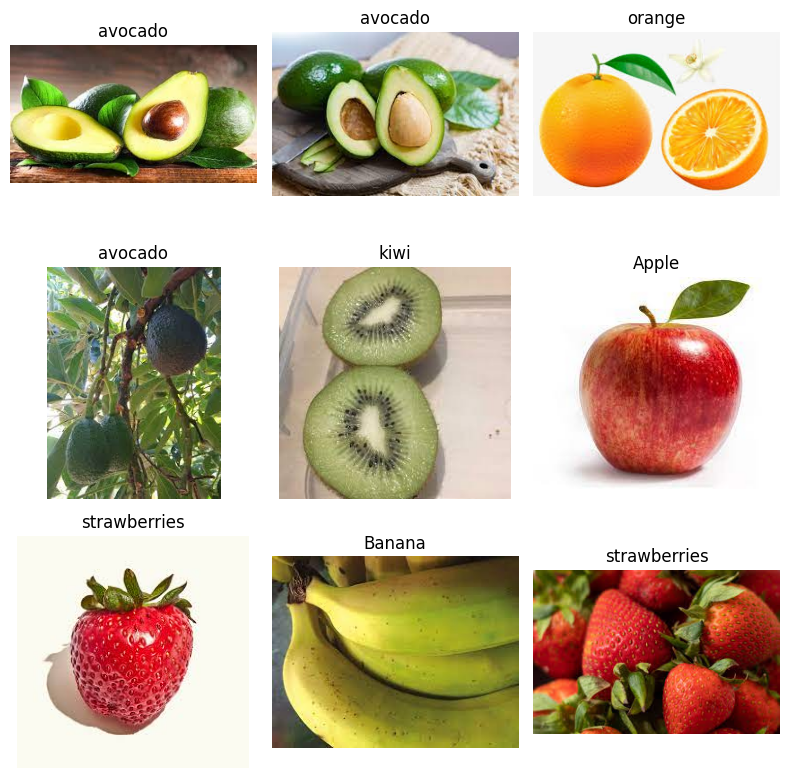

In [34]:
random_idx = np.random.randint(0, len(df), 9)
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(8,8))

for i, ax in enumerate(axes.flat):
  ax.imshow(plt.imread(df.File_Paths[random_idx[i]]))
  ax.set_title(df['Labels'][random_idx[i]])
  ax.axis('off')

plt.tight_layout()
plt.show()

In [8]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

train_df.shape, val_df.shape

((1880, 2), (471, 2))

In [9]:
datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_dataframe(
        dataframe=train_df,
        x_col='File_Paths',
        y_col='Labels',
        target_size=(224, 224),
        class_mode='sparse',
        batch_size=32,
        shuffle=True
    )

val_generator = datagen.flow_from_dataframe(
        dataframe=val_df,
        x_col='File_Paths',
        y_col='Labels',
        target_size=(224, 224),
        class_mode='sparse',
        batch_size=32,
        shuffle=True
    )

Found 1880 validated image filenames belonging to 10 classes.
Found 471 validated image filenames belonging to 10 classes.


In [10]:
def create_model():
  base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224,224, 3))
  x = base_model.output
  x = Flatten()(x)
  x = Dense(1024, activation='relu')(x)
  predictions = Dense(10, activation='softmax')(x)
  model = Model(inputs=base_model.input, outputs=predictions)

  for layer in base_model.layers:
    layer.trainable = False

  model.compile(
    optimizer='Adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

  return model

In [11]:
%%time

model = create_model()

history = model.fit(train_generator, epochs=15, validation_data=val_generator)

Epoch 1/15
59/59 [==============================] - 36s 420ms/step - loss: 3.4907 - accuracy: 0.4910 - val_loss: 0.8972 - val_accuracy: 0.6794
Epoch 2/15
59/59 [==============================] - 12s 198ms/step - loss: 0.4225 - accuracy: 0.8718 - val_loss: 0.7298 - val_accuracy: 0.7601
Epoch 3/15
59/59 [==============================] - 12s 208ms/step - loss: 0.1355 - accuracy: 0.9787 - val_loss: 0.7043 - val_accuracy: 0.7813
Epoch 4/15
59/59 [==============================] - 12s 209ms/step - loss: 0.0470 - accuracy: 0.9984 - val_loss: 0.7572 - val_accuracy: 0.7537
Epoch 5/15
59/59 [==============================] - 12s 198ms/step - loss: 0.0252 - accuracy: 1.0000 - val_loss: 0.7153 - val_accuracy: 0.7643
Epoch 6/15
59/59 [==============================] - 12s 196ms/step - loss: 0.0137 - accuracy: 1.0000 - val_loss: 0.7049 - val_accuracy: 0.7771
Epoch 7/15
59/59 [==============================] - 11s 190ms/step - loss: 0.0092 - accuracy: 1.0000 - val_loss: 0.7134 - val_accuracy: 0.7792

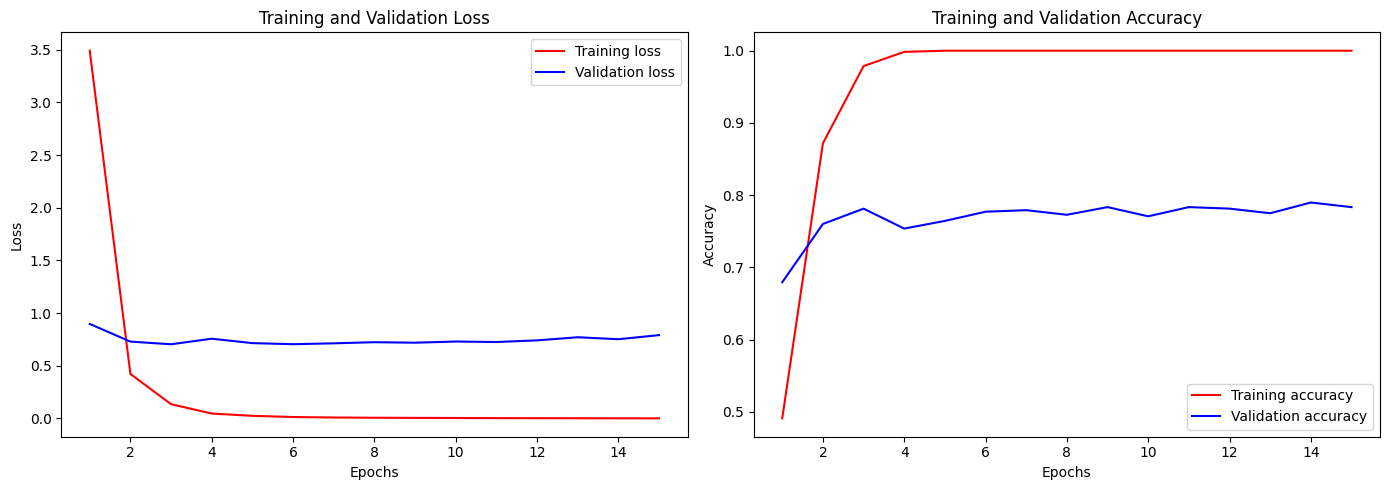

In [15]:
history_dict = history.history
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']
train_acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [13]:
test_generator = datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='File_Paths',
    y_col='Labels',
    target_size=(224,224),
    class_mode='sparse',
    batch_size=32,
    shuffle=True
)

Found 1025 validated image filenames belonging to 10 classes.


In [14]:
model.evaluate(test_generator)

33/33 [==============================] - 737s 23s/step - loss: 3.4428 - accuracy: 0.5951


[3.442774534225464, 0.5951219797134399]

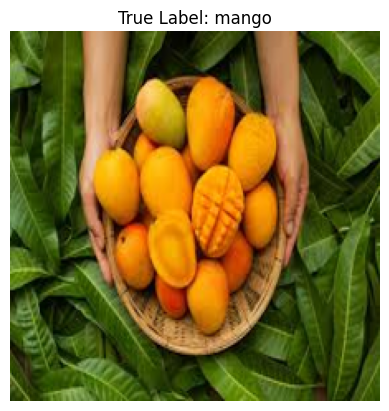

1/1 [==============================] - 0s 23ms/step
True Label: mango
Predicted Label: mango


In [29]:
def predict_random_image():

  random_idx = np.random.randint(0, len(test_df))
  random_img_path = test_df.iloc[random_idx]['File_Paths']
  true_label = test_df.iloc[random_idx]['Labels']

  img = Image.open(random_img_path)
  img = img.resize((224, 224))
  img_array = np.array(img) / 255.0

  img_array = np.expand_dims(img_array, axis=0)

  plt.imshow(img)
  plt.title(f'True Label: {true_label}')
  plt.axis('off')
  plt.show()

  predictions = model.predict(img_array)
  predicted_class_idx = np.argmax(predictions, axis=1)[0]

  class_labels = list(train_generator.class_indices.keys())
  predicted_label = class_labels[predicted_class_idx]

  print(f'True Label: {true_label}')
  print(f'Predicted Label: {predicted_label}')

predict_random_image()

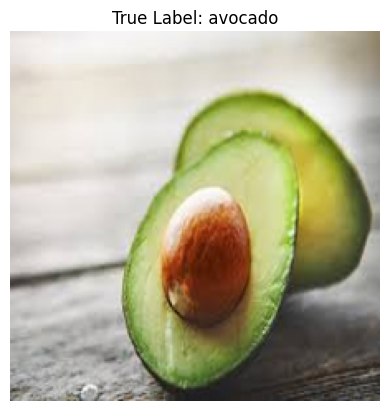

1/1 [==============================] - 0s 112ms/step
True Label: avocado
Predicted Label: avocado


In [30]:
predict_random_image()